<a href="https://colab.research.google.com/github/saritmaitra/Momentum_Trading/blob/main/SupportResistance_Experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)

[*********************100%***********************]  1 of 1 completed

18.45: 2017-01-23 00:00:00
19.35: 2017-02-02 00:00:00
22.85: 2017-03-03 00:00:00
20.0: 2017-04-10 00:00:00
19.7: 2017-04-19 00:00:00
22.35: 2017-05-22 00:00:00
23.2: 2017-06-08 00:00:00
23.1: 2017-06-26 00:00:00
24.05: 2017-07-06 00:00:00
21.9: 2017-07-25 00:00:00
10.6: 2017-09-13 00:00:00
11.4: 2017-10-12 00:00:00
9.9: 2017-10-30 00:00:00
9.9: 2017-11-16 00:00:00
10.0: 2017-12-11 00:00:00
16.3: 2018-01-23 00:00:00
16.1: 2018-02-06 00:00:00
17.2: 2018-02-26 00:00:00
17.75: 2018-03-15 00:00:00
18.5: 2018-04-16 00:00:00
18.25: 2018-04-27 00:00:00
19.95: 2018-05-23 00:00:00
16.75: 2018-06-29 00:00:00
16.3: 2018-07-16 00:00:00
18.7: 2018-08-20 00:00:00
18.5: 2018-09-05 00:00:00
17.25: 2018-09-25 00:00:00
16.87: 2018-10-08 00:00:00
15.66: 2018-10-25 00:00:00
15.22: 2018-11-09 00:00:00
14.69: 2018-12-11 00:00:00
13.67: 2019-01-24 00:00:00
13.57: 2019-02-14 00:00:00
13.75: 2019-02-26 00:00:00
14.18: 2019-03-26 00:00:00
12.1

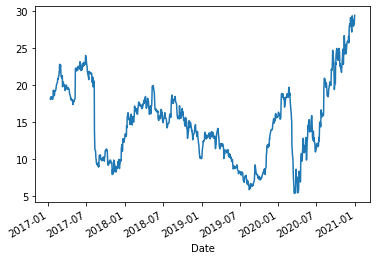

In [2]:
ticker = "SGRY"
start_date = dt.datetime(2010,12,31)
end_date = dt.datetime(2020,12,31)
class DataBase():
  def __init__(self, ticker, days):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
    self.df= self.df[-days:]

  def quote(self):
    return self.df

db = DataBase(ticker, 1000)
df = db.quote()
# print(df.tail())

df['High'].plot(Label='High')
pivots = [] # pivot values we will calculate
dates = []
counter = 0 # how many days have occured since a max has happened
lastPivot = 0 # last pivot value

Range = [0,0,0,0,0,0,0,0,0,0]
dateRange = [0,0,0,0,0,0,0,0,0,0]

df.reset_index(inplace = True)
for i in df.index:
  currentMax = max(Range, default = 0)
  value = round(df['High'][i], 2)

  Range = Range[1:9]
  Range.append(value)
  dateRange = dateRange[1:9]
  dateRange.append(i)

  if currentMax == max(Range, default=0):
    counter += 1
  else: 
    counter = 0

  if counter == 5:
    lastPivot = currentMax
    dateloc = Range.index(lastPivot)
    lastDate=df['Date'][i]
    pivots.append(lastPivot)
    dates.append(lastDate)

print()
# print(str(pivots))
# print(str(dates))
timeD = dt.timedelta(days = 30)

for index in range(len(pivots)):
  print(str(pivots[index]) + ": " + str(dates[index]))

  # plt.plot_date([dates['Date']+dates['Date']+timeD],
  #                [pivots['Date'], pivots['Date']], linestyle = "-",
  #              linewidth = 2, marker = ',')

  

plt.show()

Buy & Hold Strategy return & risk: 12.09 % and 77.55%
Support & Resistance Strategy return & risk: -47.2 % and 77.48%


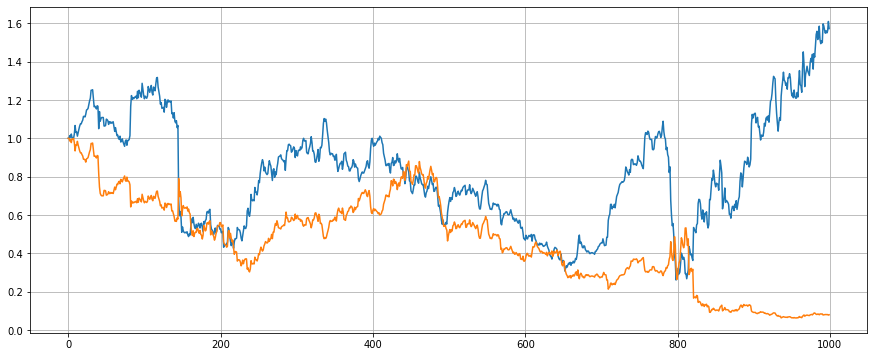

In [3]:
import numpy as np

fee = 0.0005 # 500 basis point
# thresholds
sr_sell = 0.5
sr_buy = 0.5

df['returns'] = df['Adj Close'].pct_change()
df['scaled_price'] = df['Adj Close'] / 10**np.floor(np.log10(df['Adj Close'])) # converting Adj Close price between 1 & 10 
df['S&R'] = df['scaled_price']%1
df['signal'] = 1*(df['S&R'] < sr_buy) - 1*(df['S&R'] > sr_sell)

# daily ret
BuyHold_ret = np.array(df['returns'][1:])
SR_ret = np.array(df['returns'][1:]) * np.array(df['signal'][:-1]) - fee*abs(np.array(df['signal'][1:]) - np.array(df['signal'][:-1]))

# annualized ret
BuyHold = np.prod(1 + BuyHold_ret )** (252/len(BuyHold_ret)) -1
SR = np.prod(1 + SR_ret )** (252/len(SR_ret)) -1

BuyHold_risk = np.std(BuyHold_ret)*(252)**(1/2)
SR_risk =  np.std(SR_ret)*(252)**(1/2)

print('Buy & Hold Strategy return & risk: '+str(round(BuyHold*100, 2)) +' % and '+str(round(BuyHold_risk*100, 2))+'%')
print('Support & Resistance Strategy return & risk: '+str(round(SR*100, 2)) +' % and '+str(round(SR_risk*100, 2))+'%')

plt.figure(figsize = (15,6))
plt.plot(np.append(1, np.cumprod(1+BuyHold_ret)))
plt.plot(np.append(1, np.cumprod(1+SR_ret)))
plt.grid(True); plt.show()

In [14]:
def get(tickers, startdate, enddate):
  def data(ticker):
    return (yf.download(ticker, start=startdate, end=enddate, skiprows=1,
                                parse_dates=True,
                                index_col=0))
  datas = map (data, tickers)
  return (pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
start = dt.datetime(2015,12,31)
end = dt.datetime(2020,12,31) # dt.datetime.now()
all_data = get(tickers, start, end)
all_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
SGRY   2015-12-31   21.170000   21.385000   20.240000   20.490000   20.490000   
       2016-01-04   20.110001   20.385000   19.379999   19.490000   19.490000   
       2016-01-05   19.480000   19.730000   19.190001   19.660000   19.660000   
       2016-01-06   19.420000   20.400000   19.270000   20.240000   20.240000   
       2016-01-07   20.000000   20.174999   18.809999   18.850000   18.850000   
...                       ...         ...         ...         ...         ...   
PTC    2020-12-23  119.980003  121.250000  118.870003  119.169998  119.169998   
       2020-12-24  119.820000  120.180000  119.040001  119.849998  119.849998   
       2020-12-28  121.360001  121.750000  118.000000  118.809998  118.809998   
       2020-12-29  118.800003  118.940002  116.980003  117.769997  117.769997   
       2020-12-30  118.760002  120.160004  118.300003  119.510002  119.510002   

                   Volume  
Ticker Date                
SGRY   2015-12-31  189400  
       2016-01-04  225100  
       2016-01-05  208300  
       2016-01-06  125400  
       2016-01-07  178100  
...                   ...  
PTC    2020-12-23  392600  
       2020-12-24  189400  
       2020-12-28  392700  
       2020-12-29  293400  
       2020-12-30  283300  

[10072 rows x 6 columns]

In [15]:
# Isolate the `Adj Close` values and transform the DataFrame
stocks = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')
stocks

Ticker,BPMC,DIS,FATE,GM,NTRA,PTC,SGRY,Z
Date,,,,,,,,
2015-12-31,26.340000,99.137009,3.370000,28.359617,10.800000,34.630001,20.490000,23.480000
2016-01-04,24.459999,97.155785,3.290000,27.775911,10.340000,33.730000,19.490000,22.110001
2016-01-05,22.900000,95.193428,3.310000,27.042109,10.370000,33.660000,19.660000,21.990000
2016-01-06,21.500000,94.683952,3.230000,26.074837,10.460000,33.070000,20.240000,21.959999
2016-01-07,20.730000,93.872604,2.850000,25.007492,9.890000,31.770000,18.850000,21.500000
...,...,...,...,...,...,...,...,...
2020-12-23,124.480003,173.550003,100.800003,42.450001,110.040001,119.169998,28.020000,141.229996
2020-12-24,123.000000,173.729996,99.500000,41.580002,111.739998,119.849998,27.820000,138.639999
2020-12-28,122.449997,178.860001,96.209999,41.660000,106.260002,118.809998,28.010000,132.679993


### momentum measurement function. 

We can compute the exponential regression of a stock by performing linear regression on the natural log of the stock’s daily closes:

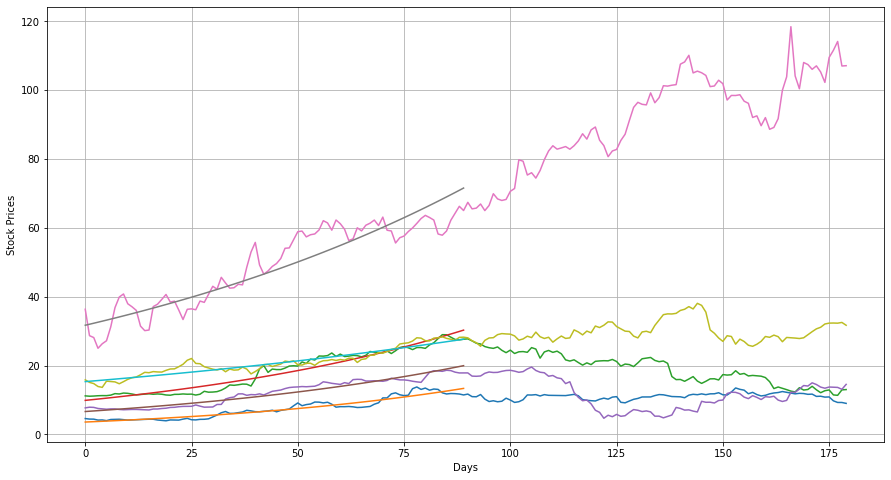

In [16]:
from scipy.stats import linregress

def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

# apply a rolling 90 day momentum calculation to all of the stocks in our universe:
momentums = stocks.copy(deep=True)
for Ticker in tickers:
    momentums[Ticker] = stocks[Ticker].rolling(90).apply(momentum, raw=False)

# Let’s look at the 5 stocks with the best momentum values and plot them along with their regression curve.
plt.figure(figsize=(15, 8))
plt.xlabel('Days')
plt.ylabel('Stock Prices')

bests = momentums.max().sort_values(ascending=False).index[:5]
for best in bests:
    end = momentums[best].index.get_loc(momentums[best].idxmax())
    rets = np.log(stocks[best].iloc[end - 90 : end])
    x = np.arange(len(rets))
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(180), stocks[best][end-90:end+90])
    plt.plot(x, np.e ** (intercept + slope*x))
    plt.grid(True)


We can see, the regression curves fit each stock quite well; The stocks do not seem to follow the curve outside of the measurement window, but it is important to remember that this momentum indicator is only used for ranking the stocks, and is in no way trying to predict prices.

## Risk Parity Sizing
Clenow’s strategy uses risk parity allocation to calculate the position sizes of each stock. Each stock is assigned a size using the following formula:

        Size= (AccountValue × RiskFactor) / ATR20


ATR20 is a stock’s Average True Range over the past 20 days. 

The risk factor, in our case, will be 10 basis points (0.1%). This means that if we assume each stock’s ATR remains similar in the future, we can expect each stock to have a daily impact of 0.1% of our portfolio. We are essentially normalizing the weights all of the stocks in our portfolio by risk.
​
## Backtesting
First we’ll code the Momentum indicator and our strategy


In [ ]:
!pip install pyfolio
import pyfolio as pf
!pip install strategies
from strategies import *
!pip install backtrader
import backtrader as bt
from backtrader.feeds import PandasData
!pip install strategies
from strategies import *
import backtrader.feeds as btfeeds
import backtrader.indicators as btind

In [35]:
...
prices = all_data.copy()
OHLCV = ['open', 'high', 'low', 'close', 'volume']
...

# class to define the columns we will provide
class SignalData(bt.feeds.PandasData):
  cols = OHLCV 
  # create lines
  lines = tuple(cols)
  # define parameters
  params = {c: -1 for c in cols}
  params.update({'datetime': None})
  params = tuple(params.items())


class Momentum(bt.Indicator):
    lines = ('trend',)
    params = (('period', 90),)
    
    def __init__(self):
        self.addminperiod(self.params.period)
    
    def log(self, txt, dt=None):
      '''Logging function'''
      # Logging function for the strategy.  
      # 'txt' is the statement and 'dt' can be used to specify a specific datetime
      if dt is None: dt = dt or self.datas[0].datetime.datetime()
      if isinstance(dt, float): dt = bt.num2date(dt)
      print('%s, %s' % (dt.isoformat(), txt))
    
    def next(self):
        returns = np.log(self.data.get(size=self.p.period))
        x = np.arange(len(returns))
        slope, _, rvalue, _, _ = linregress(x, returns)
        annualized = (1 + slope) ** 252
        self.lines.trend[0] = annualized * (rvalue ** 2)
        
        
class Strategy(bt.Strategy):
    def __init__(self):
        self.i = 0
        self.inds = {}
        self.spy = self.datas[0]
        self.stocks = self.datas[1:]
        
        self.spy_sma200 = bt.indicators.SimpleMovingAverage(self.spy.close,
                                                            period=200)
        for d in self.stocks:
            self.inds[d] = {}
            self.inds[d]["momentum"] = Momentum(d.close, 
                                                period=90)
            self.inds[d]["sma100"] = bt.indicators.SimpleMovingAverage(d.close, 
                                                                       period=100)
            self.inds[d]["atr20"] = bt.indicators.ATR(d, 
                                                      period=20)

    def prenext(self):
        # call next() even when data is not available for all tickers
        self.next()
    
    def next(self):
        if self.i % 5 == 0:
            self.rebalance_portfolio()
        if self.i % 10 == 0:
            self.rebalance_positions()
        self.i += 1
    
    def rebalance_portfolio(self):
        # only look at data that we can have indicators for 
        self.rankings = list(filter(lambda d: len(d) > 100, self.stocks))
        self.rankings.sort(key=lambda d: self.inds[d]["momentum"][0])
        num_stocks = len(self.rankings)
        
        # sell stocks based on criteria
        for i, d in enumerate(self.rankings):
            if self.getposition(self.data).size:
                if i > num_stocks * 0.2 or d < self.inds[d]["sma100"]:
                    self.close(d)
        
        if self.spy < self.spy_sma200:
            return
        
        # buy stocks with remaining cash
        for i, d in enumerate(self.rankings[:int(num_stocks * 0.2)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            if not self.getposition(self.data).size:
                size = value * 0.001 / self.inds[d]["atr20"]
                self.buy(d, size=size)
                
        
    def rebalance_positions(self):
        num_stocks = len(self.rankings)
        
        if self.spy < self.spy_sma200:
            return

        # rebalance all stocks
        for i, d in enumerate(self.rankings[:int(num_stocks * 0.2)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            size = value * 0.001 / self.inds[d]["atr20"]
            self.order_target_size(d, size)

Here, the strategy looks for stocks it needs to sell every week in the rebalance_portfolio method and rebalances all of its positions every other week in the rebalance_positions method. 

In [36]:
...
# instantiate SignalData class
data = SignalData(dataname=prices.droplevel(level=0),
                                    name=Ticker,
                                    plot=False)

cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)
cerebro.adddata(data)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(Strategy)
results = cerebro.run()

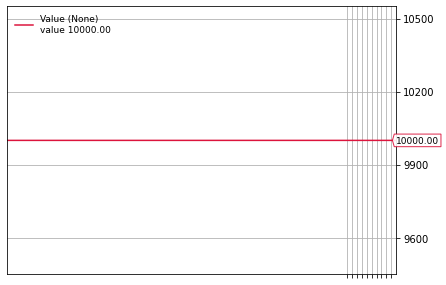

Sharpe Ratio: OrderedDict([('sharperatio', None)])
Norm. Annual Return: 0.00%
Max Drawdown: 0.00%


In [37]:
cerebro.plot(iplot=False)[0][0]
print('Sharpe Ratio:', results[0].analyzers.sharpe.get_analysis())
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")

## Optimization:

In [ ]:
pip install PyQt5

In [28]:
import os, sys
import pandas as pd
import numpy as np
import backtrader as bt
from scipy.stats import linregress
from collections import defaultdict
from tabulate import tabulate
import PyQt5
import matplotlib
import matplotlib.pyplot as plt
import backtrader.plot
from matplotlib.pyplot import figure

In [30]:
tickers = ["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]

def momentum_func(self, price_array):
    r = np.log(price_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return (annualized * (rvalue ** 2))


class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    params = dict(period=90)
    func = momentum_func


class Strategy(bt.Strategy):
    params = dict(
        momentum=Momentum,
        momentum_period=180,
        num_positions=2,
        when=bt.timer.SESSION_START,
        timer=True,
        monthdays=[1],
        monthcarry=True,
        printlog=True
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.i = 0
        self.securities = self.datas[1:]
        self.inds = {}

        self.add_timer(
            when=self.p.when,
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )

        for security in self.securities:
            self.inds[security] = self.p.momentum(security,
                                                  period=self.p.momentum_period)

    def notify_timer(self, timer, when, *args, **kwargs):
        if self._getminperstatus() < 0:
            self.rebalance()

    def rebalance(self):
        rankings = list(self.securities)
        rankings.sort(key=lambda s: self.inds[s][0], reverse=True)
        pos_size = 1 / self.p.num_positions

        # Sell stocks no longer meeting ranking filter.
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i > self.p.num_positions:
                    self.close(d)

        # Buy and rebalance stocks with remaining cash
        for i, d in enumerate(rankings[:self.p.num_positions]):
            self.order_target_percent(d, target=pos_size)

    def next(self):
        self.notify_timer(self, self.p.timer, self.p.when)

    def stop(self):
        self.log('| %2d | %2d |  %.2f |' %
                 (self.p.momentum_period,
                  self.p.num_positions,
                  self.broker.getvalue()),
                 doprint=True)

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    # instantiate SignalData class
    dataframe = SignalData(dataname=prices.droplevel(level=0),
                                    name=Ticker,
                                    plot=False)
    
    cerebro.adddata(dataframe)
   
    cerebro.optstrategy(Strategy,
                    momentum_period=range(50, 300, 50),
                    num_positions=range(1, len(tickers) + 1))

    # Run the strategy. Results will be output from stop.
    cerebro.run(stdstats=False, tradehistory=False)